<a href="https://colab.research.google.com/github/tua2542/DSLoveyou/blob/master/HousePrices_DSLoveYou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
print(tf.__version__)


2.3.0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
pizza_notPizza_dataset = "/content/drive/My Drive/Colab Notebooks/pizza_notPizza_photo_two.zip"


In [9]:
import zipfile

with zipfile.ZipFile(pizza_notPizza_dataset, 'r') as z:
    z.extractall()

In [10]:
import pathlib
pizza_notPizza_path = "/content/pizza_notPizza_photo";
data_dir = pathlib.Path(pizza_notPizza_path)

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1975


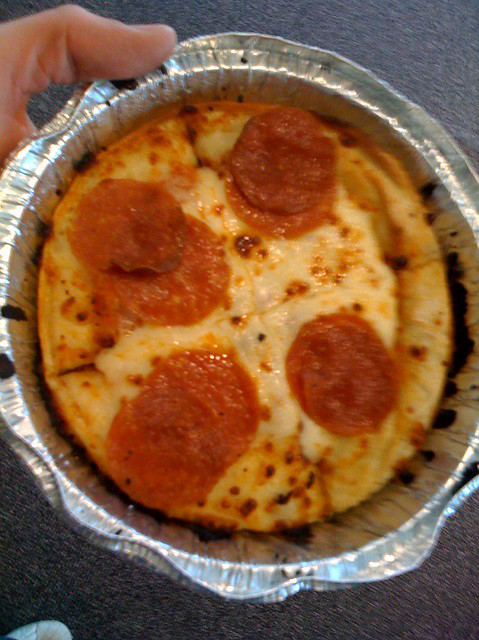

In [12]:
pizza = list(data_dir.glob('Pizza/*'))
PIL.Image.open(str(pizza[0]))


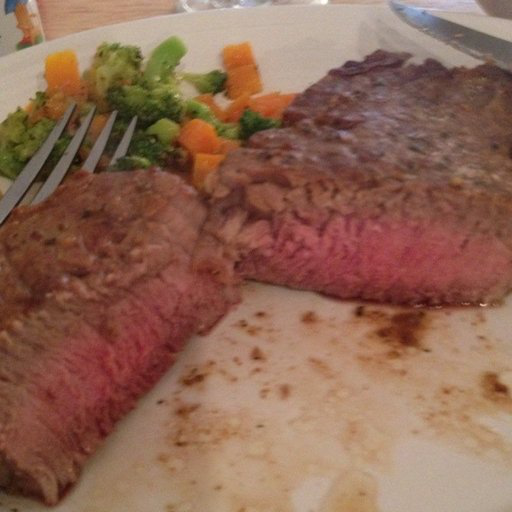

In [13]:
not_pizza = list(data_dir.glob('Not_Pizza/*'))
PIL.Image.open(str(not_pizza[0]))

In [14]:
batch_size = 32
img_height = 180
img_width = 180

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1997 files belonging to 2 classes.
Using 1598 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1997 files belonging to 2 classes.
Using 399 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['Not_Pizza', 'Pizza']


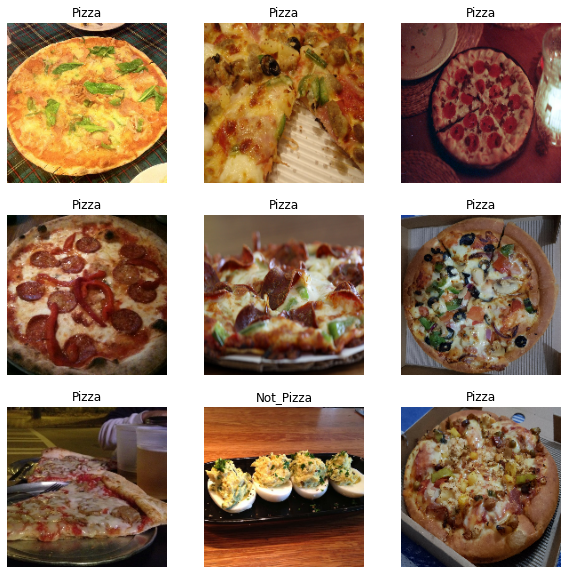

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.013397576 1.0


In [23]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
50/50 [==============================] - 54s 1s/step - loss: 0.7428 - accuracy: 0.5569 - val_loss: 0.6351 - val_accuracy: 0.5714
Epoch 2/10
50/50 [==============================] - 48s 962ms/step - loss: 0.5233 - accuracy: 0.7566 - val_loss: 0.4758 - val_accuracy: 0.7744
Epoch 3/10
50/50 [==============================] - 48s 957ms/step - loss: 0.4034 - accuracy: 0.8254 - val_loss: 0.4409 - val_accuracy: 0.8020
Epoch 4/10
50/50 [==============================] - 48s 957ms/step - loss: 0.3449 - accuracy: 0.8498 - val_loss: 0.4255 - val_accuracy: 0.8095
Epoch 5/10
50/50 [==============================] - 48s 969ms/step - loss: 0.2994 - accuracy: 0.8686 - val_loss: 0.4576 - val_accuracy: 0.8095
Epoch 6/10
50/50 [==============================] - 48s 961ms/step - loss: 0.2597 - accuracy: 0.8974 - val_loss: 0.4367 - val_accuracy: 0.8070
Epoch 7/10
50/50 [==============================] - 48s 968ms/step - loss: 0.2303 - accuracy: 0.9036 - val_loss: 0.4287 - val_accuracy: 0.7995
Ep

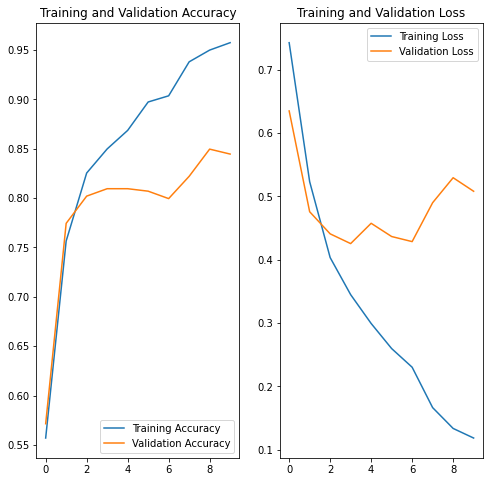

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

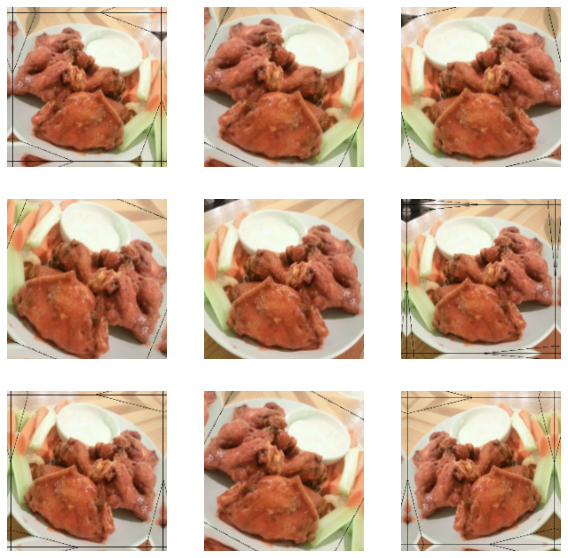

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [33]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
50/50 [==============================] - 58s 1s/step - loss: 0.5620 - accuracy: 0.7228 - val_loss: 0.4478 - val_accuracy: 0.7870
Epoch 2/15
50/50 [==============================] - 57s 1s/step - loss: 0.4321 - accuracy: 0.8110 - val_loss: 0.4365 - val_accuracy: 0.7820
Epoch 3/15
50/50 [==============================] - 57s 1s/step - loss: 0.3823 - accuracy: 0.8317 - val_loss: 0.4638 - val_accuracy: 0.7845
Epoch 4/15
50/50 [==============================] - 57s 1s/step - loss: 0.3649 - accuracy: 0.8385 - val_loss: 0.3970 - val_accuracy: 0.8321
Epoch 5/15
50/50 [==============================] - 56s 1s/step - loss: 0.3470 - accuracy: 0.8479 - val_loss: 0.4222 - val_accuracy: 0.8221
Epoch 6/15
50/50 [==============================] - 57s 1s/step - loss: 0.3410 - accuracy: 0.8486 - val_loss: 0.3868 - val_accuracy: 0.8446
Epoch 7/15
50/50 [==============================] - 57s 1s/step - loss: 0.3205 - accuracy: 0.8567 - val_loss: 0.4088 - val_accuracy: 0.8346
Epoch 8/15
50/50 [==

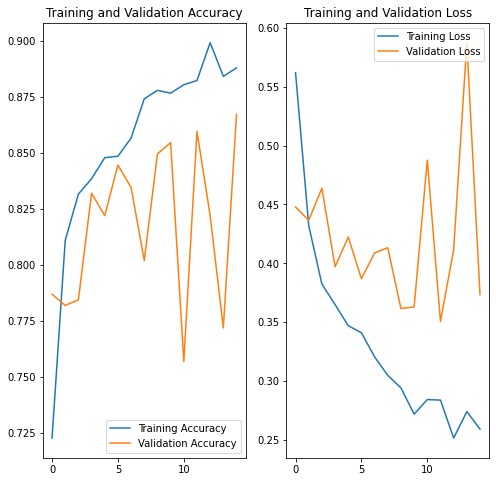

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [36]:
new_model = tf.keras.models.load_model('saved_model/my_model')
# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [37]:
# Evaluate the restored model
loss, acc = new_model.evaluate(image_batch,  labels_batch, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

print(new_model.predict(image_batch).shape)

1/1 - 0s - loss: 4.6603 - accuracy: 1.0000
Restored model, accuracy: 100.00%
(32, 2)


In [38]:
!mkdir -p saved_model
model.save('/content/saved_model/my_model/assets/my_model.h5') 

In [39]:
!mkdir -p saved_model
model.save_weights("/content/saved_model/my_model/variables/model.tf")

In [40]:
!mkdir -p saved_model
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("/content/saved_model/my_model/assets/my_model.json", "w") as json_file:
    json_file.write(model_json)

json_file = open('/content/saved_model/my_model/assets/my_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/saved_model/my_model/assets/my_model.h5")
print("Loaded model from disk")

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(train_ds)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
50/50 [==============================] - 14s 286ms/step - loss: 6.6796 - accuracy: 0.9143
accuracy: 91.43%


In [41]:
!mkdir -p saved_model
def recreate_labels():
  # 1) We use this in order to ignore any hidden files that might be here.
  # 'Datasets' is the name of the folder where we store our training data. The 'listdir' is used to fetch all the folder names.
  labels = [folder for folder in os.listdir('/content/pizza_notPizza_photo') if not folder.startswith('.')]
  
  # 2) Then, we output the contents of each folder name to a file.
  with open('/content/saved_model/labels.txt', 'w') as file:
    for label in labels:
      file.write(label)
      file.write('\n')

recreate_labels()   

Saving 89154897_2744233999026951_1694256335031369728_o.jpg to 89154897_2744233999026951_1694256335031369728_o.jpg


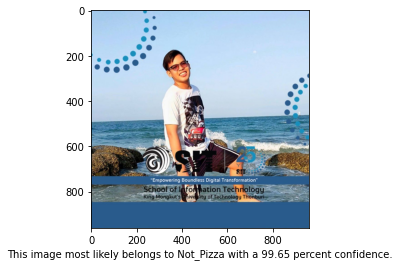

In [42]:
from google.colab import files
uploads = files.upload()

from keras.preprocessing.image import load_img
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import save_img

for file in uploads.keys() :
  # load the image 
 img = load_img(file,target_size=(img_height, img_width)) 
  # convert image to a numpy array
 img_array = img_to_array(img)
 img_array = tf.expand_dims(img_array, 0)
 # load the image to confirm it was saved correctly
 img = load_img(file)
 plt.imshow(img)
#  print(type(img))
#  print(img.format)
#  print(img.mode)
#  print(img.size)
 img.show()
 predictions = model.predict(img_array)
 score = tf.nn.softmax(predictions[0])
 plt.xlabel("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))
#  print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )